# INTRODUCTION

We try to predict the genetic disorder of patients based on multiple features

# IMPORT & SETUP

In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# from matplotlib.gridspec import GridSpec
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LeakyReLU
# from tensorflow.keras.activations import linear, relu, sigmoid
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, mean_absolute_error, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# THE DATASET

##### Features: 
###### We see here an example entry from the dataset, we count 45 features, two of which are target features
| **Column name**                                  | **Column description**                                                                                                                    |
| ------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------- |
| Patient Id                                       | Represents the unique identification number of a patient                                                                                  |
| Patient Age                                      | Represents the age of a patient                                                                                                           |
| Genes in mother's side                           | Represents a gene defect in a patient's mother                                                                                            |
| Inherited from father                            | Represents a gene defect in a patient's father                                                                                            |
| Maternal gene                                    | Represents a gene defect in the patient's maternal side of the family                                                                     |
| Paternal gene                                    | Represents a gene defect in a patient's paternal side of the family                                                                       |
| Blood cell count (mcL)                           | Represents the blood cell count of a patient                                                                                              |
| Patient First Name                               | Represents a patient's first name                                                                                                         |
| Family Name                                      | Represents a patient's family name or surname                                                                                             |
| Father's name                                    | Represents a patient's father's name                                                                                                      |
| Mother's age                                     | Represents a patient's mother's name                                                                                                      |
| Father's age                                     | Represents a patient's father's age                                                                                                       |
| Institute Name                                   | Represents the medical institute where a patient was born                                                                                 |
| Location of Institute                            | Represents the location of the medical institute                                                                                          |
| Status                                           | Represents whether a patient is deceased                                                                                                  |
| Respiratory Rate (breaths/min)                   | Represents a patient's respiratory breathing rate                                                                                         |
| Heart Rate (rates/min)                           | Represents a patient's heart rate                                                                                                         |
| Test 1 - Test 5                                  | Represents different (masked) tests that were conducted on a patient                                                                      |
| Parental consent                                 | Represents whether a patient's parents approved the treatment plan                                                                        |
| Follow-up                                        | Represents a patient's level of risk (how intense their condition is)                                                                     |
| Gender                                           | Represents a patient's gender                                                                                                             |
| Birth asphyxia                                   | Represents whether a patient suffered from birth asphyxia                                                                                 |
| Autopsy shows birth defect (if applicable)       | Represents whether a patient's autopsy showed any birth defects                                                                           |
| Place of birth                                   | Represents whether a patient was born in a medical institute or home                                                                      |
| Folic acid details (peri-conceptional)           | Represents the periconceptional folic acid supplementation details of a patient                                                           |
| H/O serious maternal illness                     | Represents an unexpected outcome of labor and delivery that resulted in significant short or long-term consequences to a patient's mother |
| H/O radiation exposure (x-ray)                   | Represents whether a patient has any radiation exposure history                                                                           |
| H/O substance abuse                              | Represents whether a parent has a history of drug addiction                                                                               |
| Assisted conception IVF/ART                      | Represents the type of treatment used for infertility                                                                                     |
| History of anomalies in previous pregnancies     | Represents whether the mother had any anomalies in her previous pregnancies                                                               |
| No. of previous abortion                         | Represents the number of abortions that a mother had                                                                                      |
| Birth defects                                    | Represents whether a patient has birth defects                                                                                            |
| White Blood cell count (thousand per microliter) | Represents a patient's white blood cell count                                                                                             |
| Blood test result                                | Represents a patient's blood test results                                                                                                 |
| Symptom 1 - Symptom 5                            | Represents (masked) different types of symptoms that a patient had                                                                        |
| Genetic Disorder                                 | Represents the genetic disorder that a patient has                                                                                        |
| Disorder Subclass                                | Represents the subclass of the disorder                                                                                                   |

In [2]:
file_path = 'dataset/train.csv'
data = pd.read_csv(file_path)

##### Target features

In [4]:
disease_col = 'Genetic Disorder'
subclass_col = 'Disorder Subclass'
grouped_data = data.groupby([disease_col, subclass_col]).size().reset_index(name='Count')
num_combinations = grouped_data.shape[0]

print("Number of entries in the dataset:", len(data))

print("\nUnique Combinations of Disease and Subclass:")
grouped_data.head(10)

Number of entries in the dataset: 22083

Unique Combinations of Disease and Subclass:


,Genetic Disorder,Disorder Subclass,Count
0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,587
1,Mitochondrial genetic inheritance disorders,Leigh syndrome,4683
2,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy,3971
3,Multifactorial genetic inheritance disorders,Alzheimer's,133
4,Multifactorial genetic inheritance disorders,Cancer,91
5,Multifactorial genetic inheritance disorders,Diabetes,1653
6,Single-gene inheritance diseases,Cystic fibrosis,3145
7,Single-gene inheritance diseases,Hemochromatosis,1228
8,Single-gene inheritance diseases,Tay-Sachs,2556


###### There are 3 genetic disorders, each with 3 subclasses. 
###### We notice that there are null entries in the target features, these will not be able to controbute to the model

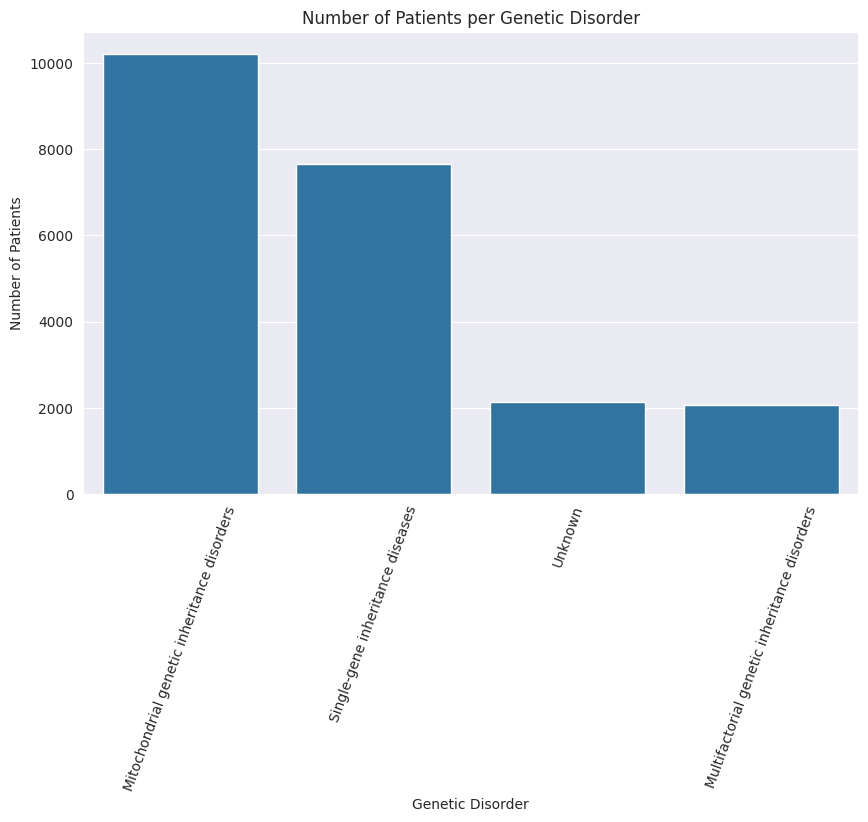

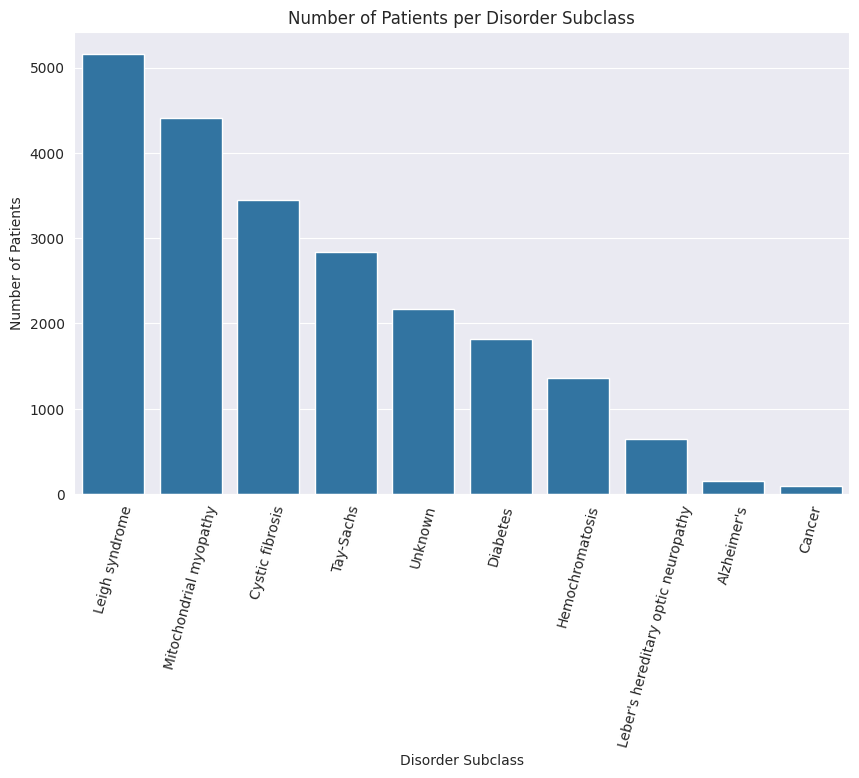

In [5]:
graph_data = data.copy().fillna(value={disease_col: "Unknown", subclass_col: "Unknown"})
# Counting patients for each disease and subclass
disease_count = graph_data[disease_col].value_counts()
subclass_count = graph_data[subclass_col].value_counts()

# Plotting Bar Chart for Diseases
plt.figure(figsize=(10, 6))
sns.barplot(x=disease_count.index, y=disease_count.values)
plt.title('Number of Patients per Genetic Disorder')
plt.ylabel('Number of Patients')
plt.xlabel('Genetic Disorder')
plt.xticks(fontsize=10, rotation=70)
plt.show()

# Plotting Bar Chart for Subclasses
plt.figure(figsize=(10, 6))
sns.barplot(x=subclass_count.index, y=subclass_count.values)
plt.title('Number of Patients per Disorder Subclass')
plt.ylabel('Number of Patients')
plt.xlabel('Disorder Subclass')
plt.xticks(fontsize=10, rotation=75)
plt.show()

##### We can change most of the unknown Genetic Disorders to be of the correct type

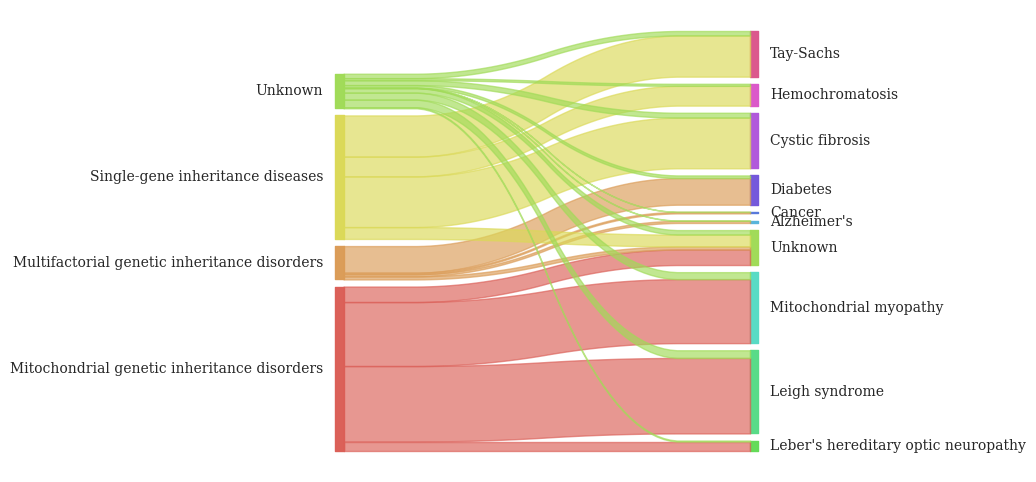

In [7]:
from pySankey import sankey

grouped_subclass = graph_data.groupby(["Genetic Disorder", "Disorder Subclass"], sort='Genetic Disorder',
                                      as_index=False).size()
count_class = graph_data.groupby(["Genetic Disorder"], sort='Genetic Disorder', as_index=False).size()

sankey.sankey(
    grouped_subclass["Genetic Disorder"], grouped_subclass["Disorder Subclass"], rightWeight=grouped_subclass['size'],
    leftWeight=grouped_subclass['size'], aspect=10, figure_name="Sankey for Genetic Disorder",
    fontsize=10
)

# PRE-PROCESSING

##### We first start by removing all the entries where both taget features are unknown.

In [71]:
print("Number of entries in the dataset before cleaning:", len(data))

grouped_data = data.groupby(['Genetic Disorder', 'Disorder Subclass'], dropna=False, as_index=False).size()
na_set = grouped_data['Genetic Disorder'].isna() & grouped_data['Disorder Subclass'].isna()
null_both_count = grouped_data[na_set]['size'].iloc[0]

print(f"Number of entries with null values in both 'Genetic Disorder' and 'Disorder Subclass': {null_both_count}")

data_1 = data.dropna(subset=["Genetic Disorder", "Disorder Subclass"], how='all')
print("Number of entries after cleaning dataset =", data_1.shape[0])

grouped_data = data_1.groupby(['Genetic Disorder', 'Disorder Subclass'], dropna=False, as_index=False).size()
na_set = grouped_data['Genetic Disorder'].isna() & grouped_data['Disorder Subclass'].isna()

null_both_count = grouped_data[na_set]['size'].size
print(f"Number of entries with null values in both 'Genetic Disorder' and 'Disorder Subclass': {null_both_count}")

data_1.head(50)

Number of entries in the dataset before cleaning: 22083
Number of entries with null values in both 'Genetic Disorder' and 'Disorder Subclass': 278
Number of entries after cleaning dataset = 21805
Number of entries with null values in both 'Genetic Disorder' and 'Disorder Subclass': 0


,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer
5,PID0x44fe,14.0,Yes,No,Yes,No,5.103188,Richard,NaN,Coleston,...,Multiple,10.272230,normal,1.0,0.0,0.0,1.0,0.0,Single-gene inheritance diseases,Cystic fibrosis
6,PID0x28de,3.0,Yes,No,Yes,Yes,4.901080,Mary,NaN,Aydun,...,Multiple,6.825974,normal,0.0,0.0,0.0,0.0,0.0,Single-gene inheritance diseases,Tay-Sachs
7,PID0x4f8f,3.0,No,No,Yes,Yes,4.964816,Emma,Bryant,Keng,...,Singular,9.836352,inconclusive,0.0,0.0,1.0,NaN,0.0,Single-gene inheritance diseases,Tay-Sachs
8,PID0x8ce3,11.0,No,No,Yes,No,5.209058,Willie,Camacho,Tr,...,Multiple,6.669552,slightly abnormal,1.0,1.0,1.0,0.0,1.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
9,PID0x8660,4.0,No,Yes,Yes,Yes,4.752272,John,Sandoval,Gregori,...,Multiple,6.397702,abnormal,0.0,0.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes


We see that there are still some entries with null values in the Genetic Disorder column, we will try to fill them using the Disorder Subclass column

In [72]:
pairs = data_1.groupby(["Disorder Subclass", "Genetic Disorder"], sort='Genetic Disorder', as_index=False).any()[
    ['Disorder Subclass', 'Genetic Disorder']]
data_1.loc[data_1['Genetic Disorder'].isna()] = data_1[
    data_1['Genetic Disorder'].isna()].reset_index().merge(
    pairs, on='Disorder Subclass', how='inner',
    suffixes=('_y', '')).drop('Genetic Disorder_y', axis=1).set_index("index")

# data_1 = data_1.loc[~data_1['Disorder Subclass'].isna()]

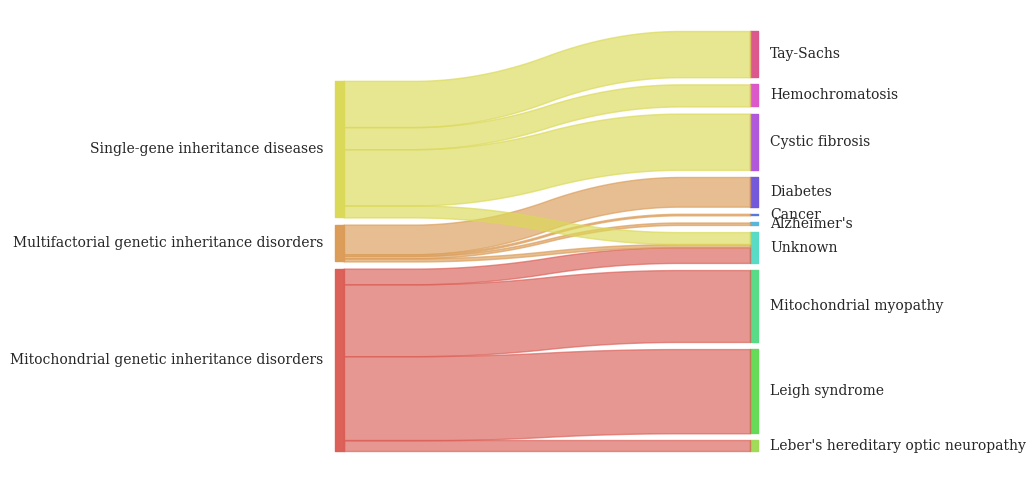

In [73]:
from pySankey import sankey

grouped_subclass = data_1.fillna(value={disease_col: "Unknown", subclass_col: "Unknown"}).groupby(
    ["Genetic Disorder", "Disorder Subclass"], sort='Genetic Disorder',
    as_index=False).size()
count_class = data_1.fillna(value={disease_col: "Unknown", subclass_col: "Unknown"}).groupby(["Genetic Disorder"],
                                                                                             sort='Genetic Disorder',
                                                                                             as_index=False).size()

sankey.sankey(
    grouped_subclass["Genetic Disorder"], grouped_subclass["Disorder Subclass"], rightWeight=grouped_subclass['size'],
    leftWeight=grouped_subclass['size'], aspect=10, figure_name="Sankey for Genetic Disorder",
    fontsize=10
)

In [74]:
data_1.groupby(by=["Patient First Name"], as_index=False, dropna=False).size().sort_values(by="size", ascending=False)

,Patient First Name,size
1101,James,417
1205,John,371
2010,Robert,352
1668,Mary,325
1722,Michael,316
...,...,...
1201,Joella,1
1194,Joaquina,1
1180,Jetta,1
1175,Jessenia,1


Let's look at each feature and see if we can classify each of their categories into floats and handle missing data
Column: [unique options list]: number of null values

##### We remove all features that don't contribute directly to the training model or features that don't provide enough information (Test 1-5)

In [76]:
# List of columns to be dropped
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", "Place of birth", "Mother's age",
                   "Father's age", 'Patient First Name', 'Family Name', 'Patient Id', 'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5',
                   'Parental consent']

data_1 = data_1.drop(columns=columns_to_drop)

KeyError: '[\'Institute Name\', \'Location of Institute\', "Father\'s name", \'Place of birth\', "Mother\'s age", "Father\'s age", \'Patient First Name\', \'Family Name\', \'Patient Id\', \'Test 1\', \'Test 2\', \'Test 3\', \'Test 4\', \'Test 5\', \'Parental consent\'] not found in axis'

In [77]:
data_1.isna().sum().sort_values(ascending=False)

Autopsy shows birth defect (if applicable)          4331
Maternal gene                                       2758
Symptom 2                                           2176
H/O substance abuse                                 2165
Gender                                              2134
Follow-up                                           2132
History of anomalies in previous pregnancies        2124
Symptom 1                                           2119
Birth defects                                       2119
White Blood cell count (thousand per microliter)    2118
No. of previous abortion                            2117
Symptom 5                                           2116
Respiratory Rate (breaths/min)                      2113
Birth asphyxia                                      2105
H/O serious maternal illness                        2103
H/O radiation exposure (x-ray)                      2103
Blood test result                                   2101
Assisted conception IVF/ART    

<Axes: >

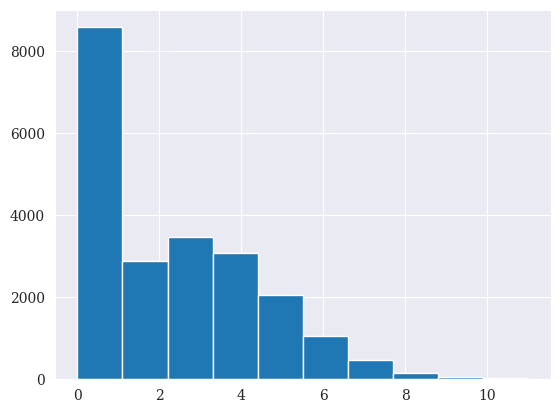

In [78]:
data_1.isna().sum(axis=1).sort_values(ascending=False).hist()

Patient Age: [ 6. 12. 11. 14.  3.  4.  7.  1.  0. 10. nan  5. 13.  8.  2.  9.]: 466

Genes in mother's side: ['Yes' 'No']: 0

Inherited from father: ['No' 'Yes' nan]: 97

Maternal gene: ['No' 'Yes' nan]: 954

Paternal gene: ['No' 'Yes']: 0

Blood cell count (mcL): [4.89329743 4.70528039 4.72070271 ... 5.1864702  4.85854267 4.73806671]: 0

Status: ['Alive' 'Deceased']: 0

Respiratory Rate (breaths/min): ['Normal (30-60)' 'Tachypnea' nan]: 723

Heart Rate (rates/min: ['Tachycardia' 'Normal' nan]: 672

Follow-up: ['Low' 'High' nan]: 689

Gender: [nan 'Male' 'Female' 'Ambiguous']: 685

Birth asphyxia: ['No record' 'Not available' 'Yes' 'No' nan]: 720

Autopsy shows birth defect (if applicable): ['Not applicable' 'No' nan 'Yes']: 2244

Folic acid details (peri-conceptional): ['Yes' 'No' nan]: 709

H/O serious maternal illness: ['No' 'Yes' nan]: 731

H/O radiation exposure (x-ray): ['Yes' '-' 'No' 'Not applicable' nan]: 724

H/O substance abuse: [nan 'Not applicable' 'No' '-' 'Yes']: 756

As

<Axes: >

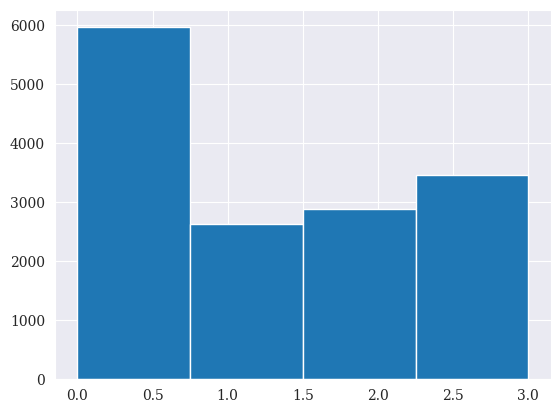

In [80]:
data_clean=data_1[data_1.isna().sum(axis=1)<4]
for column in data_clean.columns:
    unique_values = data_clean[column].unique()
    nan_counts = data_clean[column].isnull().sum()

    print(f"{column}: {unique_values}: {nan_counts}\n")
data_clean.isna().sum(axis=1).sort_values(ascending=False).hist(bins=4)

##### We see that there are still some features with missing values, we will try to imput them

In [83]:
label_encoder = LabelEncoder()

def encode(x: pd.Series):
    # Patient age --> raplce nan by median
    if x.dtype == 'object':
        return label_encoder.fit_transform(x.astype(str))
    return x

transformed_data = data_clean.apply(encode)
# transformed_data.dropna(axis=0, inplace=True)

In [88]:
transformed_data

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
2,6.0,1,0,0,0,4.893297,0,0,1,1,...,1,NaN,3,0.0,1.0,1.0,1.0,1.0,1,3
3,12.0,1,0,1,0,4.705280,1,1,0,0,...,1,7.919321,1,0.0,0.0,1.0,0.0,0.0,0,6
4,11.0,1,0,2,1,4.720703,0,1,1,1,...,0,4.098210,2,0.0,0.0,0.0,0.0,NaN,1,1
5,14.0,1,0,1,0,5.103188,1,2,0,1,...,0,10.272230,3,1.0,0.0,0.0,1.0,0.0,2,2
6,3.0,1,0,1,1,4.901080,0,0,2,1,...,0,6.825974,3,0.0,0.0,0.0,0.0,0.0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,4.0,1,1,1,0,5.258298,1,0,1,0,...,0,6.584811,1,0.0,0.0,1.0,0.0,0.0,0,6
22079,8.0,0,1,0,1,4.974220,0,0,0,0,...,0,7.041556,1,1.0,1.0,1.0,1.0,0.0,1,3
22080,8.0,1,0,1,0,5.186470,1,1,0,0,...,1,7.715464,3,0.0,0.0,0.0,1.0,NaN,0,7
22081,7.0,1,0,1,1,4.858543,0,1,1,0,...,0,8.437670,0,1.0,1.0,1.0,0.0,0.0,0,6


In [85]:
knn_imputer = KNNImputer(n_neighbors=100, weights="uniform")
data_array = knn_imputer.fit_transform(transformed_data)


In [180]:
data_array = dataset.to_numpy()


In [182]:
data_array[:, 0:28]

array([[-0.125,  0.   ,  0.   , ...,  0.   ,  1.   ,  1.   ],
       [ 0.625,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.5  ,  0.   ,  0.   , ..., -1.   ,  0.   , -1.   ],
       ...,
       [ 0.125,  0.   ,  0.   , ..., -1.   ,  1.   , -1.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.5  ,  0.   ,  0.   , ...,  0.   ,  1.   ,  1.   ]])

In [205]:
# Splitting the complete_data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_array[:, 0:28], data_array[:,29 ], test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
sel = SelectFromModel(model, threshold="median")
sel.fit(X_train, y_train)
model.fit(X_train[:, sel.get_support()], y_train)

y_pred = model.predict(X_test[:, sel.get_support()])
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.3055276381909548


In [206]:
sel.get_support()


array([ True, False, False, False, False,  True, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True])

In [175]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

X_Train, X_Test, Y_Train, Y_Test = train_test_split(data_array[:, 0:28], data_array[:, 29], test_size=0.2, random_state=42)

# X_Train = Scaler_Function.fit_transform(X_Train)
# X_Test = Scaler_Function.fit_transform(X_Test)
lj_m = LogisticRegression(solver="liblinear").fit(X_Train,Y_Train)
gnb_m = GaussianNB().fit(X_Train,Y_Train)
knnc_m = KNeighborsClassifier().fit(X_Train,Y_Train)
cartc_m = DecisionTreeClassifier(max_depth=20,min_samples_leaf=50,random_state=42).fit(X_Train,Y_Train)
rfc_m = RandomForestClassifier(random_state=42,verbose=False).fit(X_Train,Y_Train)
gbmc_m = GradientBoostingClassifier(verbose=False).fit(X_Train,Y_Train)
xgbc_m = XGBClassifier().fit(X_Train,Y_Train)
# lgbmc_m = LGBMClassifier().fit(X_Train,Y_Train)
model_m = [lj_m,gnb_m,knnc_m,cartc_m,rfc_m,gbmc_m, xgbc_m]
for model in model_m:
    name = model.__class__.__name__
    predict = model.predict(X_Test)
    f1 = f1_score(Y_Test, predict, average='macro')
    error = -cross_val_score(model,X_Test,Y_Test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
    print(name + ": ")
    print("-" * 10)
    print("ACC-->",accuracy_score(Y_Test,predict))
    print("F1-->", f1)
    print("MEAN SQUARED ERROR-->",np.sqrt(error))
    print("-" * 30)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Let's try to impute the missing values by predicting them from the complete subset

In [173]:
from sklearn.preprocessing import RobustScaler

label_encoder = LabelEncoder()

#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#

# remove rows where both targets NaN
dataset = data_clean.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')


#  NUMERICAL --> MEDIAN IMPUTER
imputer = SimpleImputer(strategy='median')
dataset['Patient Age'] = imputer.fit_transform(dataset[['Patient Age']])
# dataset["Mother\'s age"] = imputer.fit_transform(dataset[['Mother\'s age']])
# dataset["Father\'s age"] = imputer.fit_transform(dataset[['Father\'s age']])
dataset['No. of previous abortion'] = imputer.fit_transform(dataset[['No. of previous abortion']])
dataset['White Blood cell count (thousand per microliter)'] = imputer.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])


# SCALE
robust_scaler = RobustScaler()
dataset['Patient Age'] = robust_scaler.fit_transform(dataset[['Patient Age']])
dataset['White Blood cell count (thousand per microliter)'] = robust_scaler.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])
dataset['Blood cell count (mcL)'] = robust_scaler.fit_transform(dataset[['Blood cell count (mcL)']])
dataset['No. of previous abortion'] = robust_scaler.fit_transform(dataset[['No. of previous abortion']])




# CATEGORIAL BINARY
mode_imputer = SimpleImputer(strategy='most_frequent')
dataset['Autopsy shows birth defect (if applicable)'] = dataset['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0}).fillna(0.0)
# dataset['Parental consent'] = dataset['Parental consent'].replace('Yes', 1.0).fillna(0.0)
dataset['H/O substance abuse'] = dataset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0}).fillna(-1.0)
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes':1.0}).fillna(-1.0)
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes':1.0}).fillna(0.0)
dataset['History of anomalies in previous pregnancies'] = dataset['History of anomalies in previous pregnancies'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O serious maternal illness'] = dataset['H/O serious maternal illness'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O radiation exposure (x-ray)'] = dataset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0}).fillna(0.0)

# dataset['Place of birth'] = dataset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
# dataset['Place of birth'] = mode_imputer.fit_transform(dataset[['Place of birth']])
# NaN non imputed --> -1.0
dataset['Birth asphyxia'] = dataset['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': -1.0, 'Yes':1.0}).fillna(-1.0)

dataset['Respiratory Rate (breaths/min)'] = dataset['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
dataset['Respiratory Rate (breaths/min)'] = mode_imputer.fit_transform(dataset[['Respiratory Rate (breaths/min)']]) 

dataset['Heart Rate (rates/min'] = dataset['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
dataset['Heart Rate (rates/min'] = mode_imputer.fit_transform(dataset[['Heart Rate (rates/min']])
dataset['Follow-up'] = dataset['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
dataset['Follow-up'] = mode_imputer.fit_transform(dataset[['Follow-up']])

dataset['Folic acid details (peri-conceptional)'] = dataset['Folic acid details (peri-conceptional)'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Assisted conception IVF/ART'] = dataset['Assisted conception IVF/ART'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Birth defects'] = dataset['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0}).fillna(-1.0)

# CATEGORIAL MULTICLASS
dataset['Gender'] = dataset['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0}).fillna(2.0)
dataset['Gender'] = robust_scaler.fit_transform(dataset[['Gender']])
dataset['Blood test result'] = dataset['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1.0, 'slightly abnormal': 0.5, 'abnormal': 1.0}).fillna(-1.0)
dataset['Blood test result'] = robust_scaler.fit_transform(dataset[['Blood test result']])

# BINARY FEATURES WITH NO NaN
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Status"] = dataset["Status"].replace({'Alive': 0.0, 'Deceased': 1.0})

dataset['Symptom 1'] = dataset['Symptom 1'].fillna(-1.0)
dataset['Symptom 2'] = dataset['Symptom 2'].fillna(-1.0)
dataset['Symptom 3'] = dataset['Symptom 3'].fillna(-1.0)
dataset['Symptom 4'] = dataset['Symptom 4'].fillna(-1.0)
dataset['Symptom 5'] = dataset['Symptom 5'].fillna(-1.0)
dataset['Genetic Disorder'] = label_encoder.fit_transform(dataset['Genetic Disorder'].astype(str))
dataset['Disorder Subclass'] = label_encoder.fit_transform(dataset['Disorder Subclass'].astype(str))
#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#


# print("---------------------------------------DATA OVERVIEW-------------------------------------")
# i=1
# for column in dataset.columns:
#     i=i+1
#     unique_values = dataset[column].unique()
#     nan_counts = (dataset[column] == -1.0).sum()
# 
#     print(f"{column}: {unique_values}: {nan_counts}\n")
# print(i)
# print("---------------------------------------END DATA OVERVIEW-------------------------------------")    

dataset.iloc[:, 0:28] = robust_scaler.fit_transform(dataset.iloc[:, 0:28])


In [174]:
dataset

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
2,-0.125,0.0,0.0,-1.0,0.0,-0.020825,0.0,0.0,1.0,0.0,...,0.0,0.000000,0.000000,-1.0,0.0,0.0,1.0,1.0,1,3
3,0.625,0.0,0.0,0.0,0.0,-0.717591,1.0,1.0,0.0,1.0,...,0.0,0.112221,-0.666667,-1.0,-1.0,0.0,0.0,0.0,0,6
4,0.500,0.0,0.0,-1.0,1.0,-0.660438,0.0,1.0,1.0,0.0,...,1.0,-0.877143,-0.666667,-1.0,-1.0,-1.0,0.0,-1.0,1,1
5,0.875,0.0,0.0,0.0,0.0,0.757002,1.0,0.0,0.0,0.0,...,1.0,0.721437,0.000000,0.0,-1.0,-1.0,1.0,0.0,2,2
6,-0.500,0.0,0.0,0.0,1.0,0.008015,0.0,0.0,0.0,0.0,...,1.0,-0.170869,0.000000,-1.0,-1.0,-1.0,0.0,0.0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,-0.375,0.0,1.0,0.0,0.0,1.331818,1.0,0.0,1.0,1.0,...,1.0,-0.233311,-0.666667,-1.0,-1.0,0.0,0.0,0.0,0,6
22079,0.125,-1.0,1.0,-1.0,1.0,0.279065,0.0,0.0,0.0,1.0,...,1.0,-0.115051,-0.666667,0.0,0.0,0.0,1.0,0.0,1,3
22080,0.125,0.0,0.0,0.0,0.0,1.065633,1.0,1.0,0.0,1.0,...,0.0,0.059438,0.000000,-1.0,-1.0,-1.0,1.0,-1.0,0,7
22081,0.000,0.0,0.0,0.0,1.0,-0.149622,0.0,1.0,1.0,1.0,...,1.0,0.246432,0.666667,0.0,0.0,0.0,0.0,0.0,0,6


<Axes: >

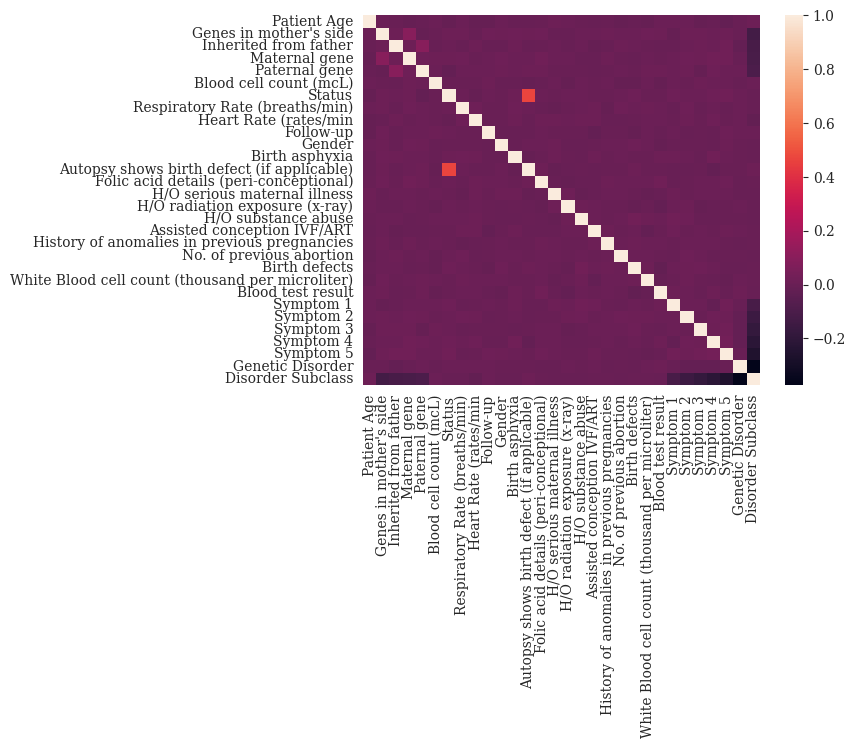

In [148]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False)

## testing some things out
